# Tasks Minichallenge 1 hpc

## Part 1: Kafka Cluster and Application Setup

### Data Generator functions
The first functions utilizes the Binance Websocket (https://www.binance.com/en/support/faq/binance-options-api-interface-and-websocket-fe0be251ac014a8082e702f83d089e54). It provides data from several different assets with an update speed of 1000ms. The function is written in *notebooks/binance_producer.py* and is started with the docker-compose file *notebooks/docker-compose.yml*. It uses JSON for serializing the data. 

The second functions makes calls to the twitter API and retrieves the most recent tweets regarding cryptocurrencies. The function is written in *notebooks/twitter_producer.py* and also gets started withthe docker-compose file *notebooks/docker-compose.yml*. It uses pickle for serializing the data. 

### Data Processor and Data Sinks
The first data processor for the Binance Websocket Producer retrieves all messages, calculates either a mean, a sum or takes the first and last value recorded. The transformation is made in a Pandas DataFrame and the values get stored in a HDF5 File. 

The second data processor retrieves the messages from the twitter producer and transforms the text of the released tweets. In the first step a text preprocessing is applied and then a sentiment analysis is performed. After this, the calculated values and the text is stored in a HDF5 file. 

### Application components and data flow
![](Application_Overview.png)

#### What are the tasks of the components?
* twitter_producer.py: Making calls to the API every 10 seconds to stay within API limits. Send whole response to Kafka using the pickle serializer. 
* twitter_processor.py: Consuming the messages in the set time interval. Deserializing the data, applying the text transformation and writing the data to the HDF5 File. 
* binance_producer.py: Opening a connection to the binance websocket and maintaining it. Serializing the data using JSON and the utf-8 encoding. Sending the data to Kafka. 
* binance_processor.py: Consuming the messages in the set time interval. Deserializing data, calculating desired values and storing data in HDF5 File. 

#### Which interfaces do the components have?
* twitter_producer.py: The data generator for the twitter data uses the REST API of Twitter and a Kafka Producer. 
* twitter_processor.py: The data processor for the twitter data uses a Kafka Consumer and HDF5 Files. 
* binance_producer.py: The data generator for the binance data uses the Websocket from Binance and a Kafka Producer. 
* binance_processor.py: The data processor for the binance data uses a Kafka Consumer and HDF5 Files. 

#### Why did you devide to use these components?
The only design choice available were the HDF5 files. HDF5 files provide the following advantages:
* well-suited for large amounts of data
* fast write and append operations
* ability to create multiple dataframes within one file
* self-explaining file format

#### Are there any other design decisions you have made?
I choose to use pandas for the calculation of the mean, min and max values for the binance data. Pandas dataframes are easy and fast to construct with JSON data. Transforming them into numpy array would have been more complicated.

#### Which requirements (e.g. libraries, hardware, ...) does a component have?
* twitter_producer.py:
  * kafka
  * pickle
  * requests
* twitter_processor.py
  * kafka
  * h5py
  * nltk
* binance_producer.py
  * websockets
  * kafka
* binance_processor.py
  * pandas
  * h5py
  * kafka

## Part 2: Communication Patterns

### Rewritten Application and containerization
The rewritten application is in the *zmq* folder and can be started with the *zmq/docker-compose.yml* file. It is written using the zeromq framework. 

### Questions
#### Which communication pattern is used by Kafka?
Kafka uses a pub-sub communication pattern. Kafka uses Producers, Consumers and Brokers. Producers produce or publish the messages to a topic, Consumers subscribe to a topic and receive the messages. The broker receives and persists messages directly on the disk. If the messages are consumed by a consumer, they still persist on the disk for consumers. 

#### What is the difference compared to your choosen pattern?
The implementation with zeromq has no service in the middle. It's a push-pull messaging pattern. The generator sends the data directly to the processor or processors. If the data generator service is connected to a port and sends the messages while the receiving service is not running, messages get lost. No messages are persisted within the pattern. Handling bottlenecks or service failures are up to the user. 

#### What are advantages and disadvantages of these patterns?
High performance: ZeroMQ is designed for high-performance messaging, with low latency and high throughput.
Lightweight: ZeroMQ is a lightweight library that is easy to use and integrate into applications.
Flexibility: ZeroMQ provides a wide range of messaging patterns and supports multiple programming languages.
Decentralized: ZeroMQ does not require a centralized message broker, making it a more decentralized messaging system.
Low latency: ZeroMQ's design minimizes latency by avoiding the need for a central broker and using efficient message passing.

##### Push-Pull ZeroMQ
**Advantages:**
* High performance: ZeroMQ is designed for high-performance messaging with low latency and high throughput. 
* Lightweight library
* Flexible message patterns

**Disadvantages:**
* Messages get lost when the data processor is not connected to the data generator. No message persistance. 
* Limited scalability. ZeroMQ's performance can degrade if the number of nodes in a network grows. 
* Has no fault-tolerance. 
* If multiple pull nodes are started, the signals are distributed and no overview of all the incoming messages is available.

##### Pub-Sub Kafka
**Advantages:**
* Kafka is designed for scalability and can handle a large number of consumers. 
* Kafka allows stream processing. The data can be processed and analyzed as it is ingested into the system. 

**Disadvantages:**
* Higher latency
* Complexity

#### How can you scale the two different approaches? What are challenges to be considered?
##### Kafka
Since Kafka is designed to be scaled, there are less challenges compared to ZeroMQ. However, the following challenges can arise:
* Hardware limitations. As the cluster grows more ressources are required. 
* Monitoring. As the cluster grows and is distributed across multiple data centers, monitoring and managing gets more complex. 
* Consumer lag. If consumers can't keep up with the incoming message rate it starts lagging behind and starts impairing the performance of the system.

##### ZeroMQ
* Ressource limitations. As the network grows, more ressources are required.
* Synchronization. ZeroMQ provides asynchronous messaging which can be challenging to synchronize across multiple nodes. The message patterns needs to be designed accordingly. 
* As the system grows it also gets more prone to errors. Since ZeroMQ has no fault-tolerance built in and no messages are persisted a error handling system needs to be implemented. 
* Security. If the data is sent over the internet, encryption and authentication needs to be implemented. 

#### What other 2-3 topologies/patterns do you know used for data processing? Describe the differences and use cases with at least one additional topology.

##### Request/Response
The request and response pattern can be used in distributed systems. Clients send requests to a system, which sends a response back. This pattern is also known as the Client-Server pattern. 

The request and response pattern is very easy to implement and to understand. The pattern is also highly scalable as multiple clients can make requests to the server which can handle them in parallel. This pattern is also very reliable since the client waits for the response before further processing. 

Typical use cases would be web applications and a variety of distributed systems where message delivery is critical. 

##### Exclusive pair
An exclusive pair is consists of one sender and one receiver only. The exclusive pair is very simple to implement since only two nodes are necessary for communication. 

The exclusive pair also guarantees message delivery and is suitable for applications where message delivery is critical. A disadvantage is the scalability. Since the message pattern can only consist of two nodes, the only possibility for scaling is vertical. 

Typical use cases would be applications where it is critical that messages sent are received. Another use case would be when a ressource is allowed to only be accessed from one client. The exclusive pair could be used to lock out the other clients. 

##### Fan-out messaging
Fan-out messaging is a system with one sender and multiple receivers. The messages are sent in a one to many fashion. In this system the sender doesn't know about the receivers and vice versa. The receivers are only responsible for receiving and processing the data. 

Fan-out messaging patterns are scalable. More receivers can be added easily and the sender can send a message in parallel to a large number of receivers. The fan-out messaging pattern is very flexible. Receivers can be added and removed without any changes to the sender. During removal or addition of receivers the sender can also continue to send messages. 

Typical use cases would be broadcasting news to a large number of clients simultaneously. Another typical application would be sending out notifications for events like system failures or maintenance updates. 

#### Which pattern suits your chosen application best?
It's not critical that every message that's sent is also received. The binance processor calculates the values every minute. If a single or even more values are missing, the results are not affected by a lot. 
Same goes for the tweets. The query can't receive all the published tweets. There will always be missing tweets. So when a single tweet is missing, it's not a problem. So the push-pull pattern is suited for both applications. If the throughput would increase and a single receiver is not able to keep up more receivers could be added. 

## Part 3: Performance Analysis and Evaluation

In [2]:
from datetime import datetime
import time
import json
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import subprocess

In [3]:
def three_broker_secrets():
    # adding brokers to services
    with open("notebooks/secrets_docker.env", "r") as f:
        secrets = json.loads(str(f.read()))

    secrets["servers"] = ["broker1:9093", "broker2:9095", "broker3:9097"]

    with open("notebooks/secrets_docker.env", "w") as f:
        f.write(json.dumps(secrets))

def six_broker_secrets():
    # adding brokers to services
    with open("notebooks/secrets_docker.env", "r") as f:
        secrets = json.loads(str(f.read()))
    secrets["servers"] = ["broker1:9093", "broker2:9095", "broker3:9097", "broker4:9099", "broker5:10001", "broker6:10003"]

    with open("notebooks/secrets_docker.env", "w") as f:
        f.write(json.dumps(secrets))

In [7]:
three_broker_secrets()

In [8]:
def plot_processing_histograms(df:pd.DataFrame):

    if len(df.process_name.unique()) > 1:
        fig, axs = plt.subplots(nrows=len(df.process_name.unique()), figsize=(10,8))
        for i, process in enumerate(list(df.process_name.unique())):
            tmp_plot_df = df[df['process_name'] == process].copy()
            mean, std = tmp_plot_df.duration.mean(), tmp_plot_df.duration.std()

            axs[i].hist(tmp_plot_df.duration, bins=20, label=f"Process times {process}")
            axs[i].set_title(f"Measured process durations for {process}")
            axs[i].set_ylabel("Number of occurences")
            axs[i].set_xlabel("Processing times [s]")
            axs[i].axvline(mean, color='red', linestyle='dashed', linewidth=2, label="Mean")
            axs[i].axvline(mean - std, color='gray', linestyle='dashed', linewidth=1, label="Standard Deviation")
            axs[i].axvline(mean + std, color='gray', linestyle='dashed', linewidth=1)
            axs[i].legend()   
            
        plt.tight_layout()
        plt.show()
    else:
        fig, axs = plt.subplots(nrows=len(df.process_name.unique()), figsize=(10,4))
        tmp_plot_df = df.copy()
        process = df.process_name.unique()[0]
        mean, std = tmp_plot_df.duration.mean(), tmp_plot_df.duration.std()

        axs.hist(tmp_plot_df.duration, bins=20, label=f"Process times {process}")
        axs.set_title(f"Measured process durations for {process}")
        axs.set_ylabel("Number of occurences")
        axs.set_xlabel("Processing times [s]")
        axs.axvline(mean, color='red', linestyle='dashed', linewidth=2, label="Mean")
        axs.axvline(mean - std, color='gray', linestyle='dashed', linewidth=1, label="Standard Deviation")
        axs.axvline(mean + std, color='gray', linestyle='dashed', linewidth=1)
        axs.legend()   
            
        plt.tight_layout()
        plt.show()

In [7]:
def plot_comparison_to_baseline(baseline_df:pd.DataFrame, df:pd.DataFrame):
    if len(df.process_name.unique()) > 1:
        fig, axs = plt.subplots(nrows=len(df.process_name.unique()), ncols=2, figsize=(8,8))

        for i, process in enumerate(list(df.process_name.unique())):
            tmp_plot_df = df[df['process_name'] == process].copy()
            mean, std = tmp_plot_df.duration.mean(), tmp_plot_df.duration.std()

            axs[i, 0].hist(tmp_plot_df.duration, bins=20, label=f"Process times {process}")
            axs[i, 0].set_title(f"Measured process durations for {process}")
            axs[i, 0].set_ylabel("Number of occurences")
            axs[i, 0].set_xlabel("Processing times [s]")
            axs[i, 0].axvline(mean, color='red', linestyle='dashed', linewidth=2, label="Mean")
            axs[i, 0].axvline(mean - std, color='gray', linestyle='dashed', linewidth=1, label="Standard Deviation")
            axs[i, 0].axvline(mean + std, color='gray', linestyle='dashed', linewidth=1)
            axs[i, 0].legend()
            
            tmp_baseline_df = baseline_df[baseline_df['process_name'] == process].copy()
            mean, std = tmp_baseline_df.duration.mean(), tmp_baseline_df.duration.std()
            axs[i, 1].hist(tmp_baseline_df.duration, bins=20, label=f"Process times {process}")
            axs[i, 1].set_title(f"Measured process durations for {process} in Baseline")
            axs[i, 1].set_ylabel("Number of occurences")
            axs[i, 1].set_xlabel("Processing times [s]")
            axs[i, 1].axvline(mean, color='red', linestyle='dashed', linewidth=2, label="Mean")
            axs[i, 1].axvline(mean - std, color='gray', linestyle='dashed', linewidth=1, label="Standard Deviation")
            axs[i, 1].axvline(mean + std, color='gray', linestyle='dashed', linewidth=1)
            axs[i, 1].legend()

    else:
        fig, axs = plt.subplots(nrows=len(df.process_name.unique()), ncols=2, figsize=(8,4))
        tmp_plot_df = df.copy()
        tmp_baseline_df = baseline_df.copy()
        process = df.process_name.unique()[0]
        mean, std = tmp_plot_df.duration.mean(), tmp_plot_df.duration.std()
        
        axs[0].hist(tmp_plot_df.duration, bins=20, label=f"Process times {process}")
        axs[0].set_title(f"Measured process durations for {process}")
        axs[0].set_ylabel("Number of occurences")
        axs[0].set_xlabel("Processing times [s]")
        axs[0].axvline(mean, color='red', linestyle='dashed', linewidth=2, label="Mean")
        axs[0].axvline(mean - std, color='gray', linestyle='dashed', linewidth=1, label="Standard Deviation")
        axs[0].axvline(mean + std, color='gray', linestyle='dashed', linewidth=1)
        axs[0].legend()   
        
        mean, std = tmp_baseline_df.duration.mean(), tmp_baseline_df.duration.std()
        
        axs[1].hist(tmp_baseline_df.duration, bins=20, label=f"Process times {process}")
        axs[1].set_title(f"Measured process durations for {process} in Baseline")
        axs[1].set_ylabel("Number of occurences")
        axs[1].set_xlabel("Processing times [s]")
        axs[1].axvline(mean, color='red', linestyle='dashed', linewidth=2, label="Mean")
        axs[1].axvline(mean - std, color='gray', linestyle='dashed', linewidth=1, label="Standard Deviation")
        axs[1].axvline(mean + std, color='gray', linestyle='dashed', linewidth=1)
        axs[1].legend()   
            
    plt.tight_layout()
    plt.show()

In [10]:
def compare_function_calls(df:pd.DataFrame, baseline_df:pd.DataFrame, labels:list=["Experiment", "Baseline"]):
    fig, axs = plt.subplots(nrows=2, figsize=(8,8))

    tmp_twitter_df = df[df.service_name.str.contains("twitter")]
    tmp_twitter_df = tmp_twitter_df.process_name + " " + tmp_twitter_df.service_name
    tmp_binance_df = df[df.service_name.str.contains("binance")]
    tmp_binance_df = tmp_binance_df.process_name +  " " + tmp_binance_df.service_name

    tmp_baseline_twitter_df = baseline_df[baseline_df.service_name.str.contains("twitter")]
    tmp_baseline_twitter_df = tmp_baseline_twitter_df.process_name + " " + tmp_baseline_twitter_df.service_name
    tmp_baseline_binance_df = baseline_df[baseline_df.service_name.str.contains("binance")]
    tmp_baseline_binance_df = tmp_baseline_binance_df.process_name + " " + tmp_baseline_binance_df.service_name

    axs[0].hist([tmp_twitter_df, tmp_baseline_twitter_df], orientation="horizontal", label=labels)
    axs[0].set_title("Process Calls Twitter")
    axs[0].set_xlabel("Number of Calls")
    axs[0].set_ylabel("Process Name")

    axs[1].hist([tmp_binance_df, tmp_baseline_binance_df], orientation="horizontal", label=labels)
    axs[1].set_title("Process Counts Binance")
    axs[1].set_xlabel("Number of Calls")
    axs[1].set_ylabel("Process Name")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

### Baseline Performance

In [11]:
three_broker_secrets()
!cd notebooks && docker-compose up --build -d
start = datetime.now()

completed_measurement = False

while completed_measurement == False:
    if (datetime.now() - start).seconds >= 5 * 60:
        completed_measurement = True
    else:
        time.sleep(1)

!cd notebooks && docker-compose down

[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/1)                                                         
 => [notebooks-twitter_processor internal] load build definition from Doc  0.0s
 => => transferring dockerfile:                                            0.0s
[+] Building 0.1s (1/2)                                                         
 => [notebooks-twitter_processor internal] load build definition from Doc  0.0s
 => => transferring dockerfile:

KeyboardInterrupt: 

In [ ]:
for filename in os.listdir("notebooks/data"):
    if filename.startswith("pe"):
        df = pd.read_pickle("notebooks/data/" + filename)

### Process times binance processor

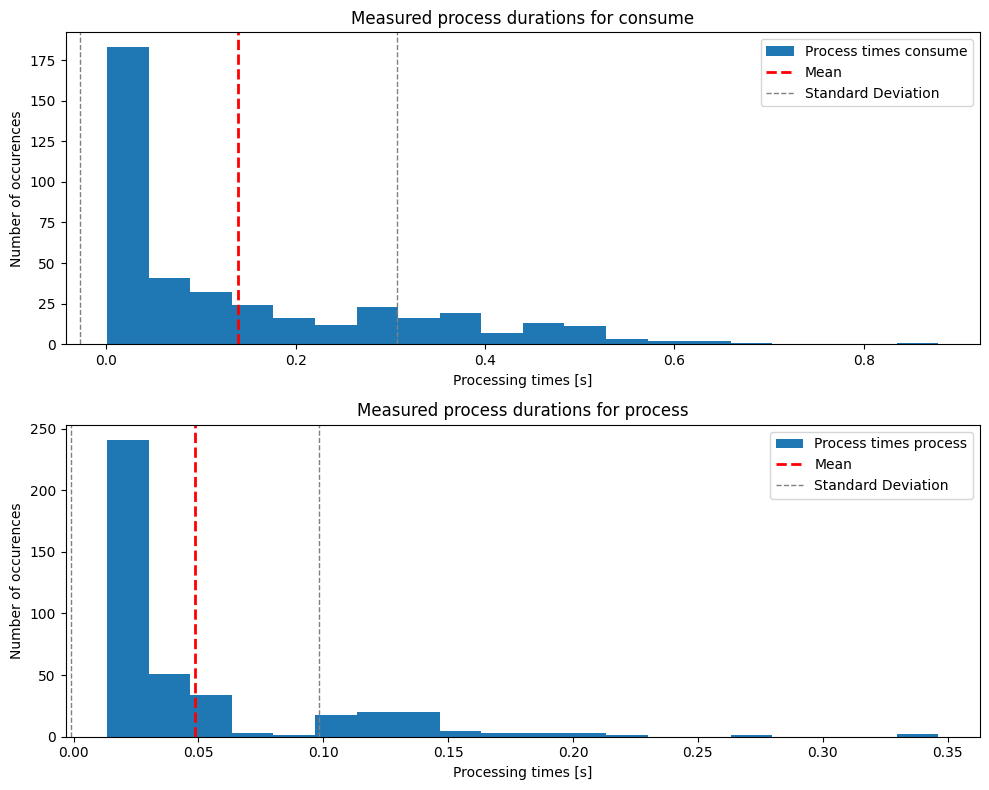

In [ ]:
binance_processor_df = pd.DataFrame(df[df.service_name == "binance_processor"])
plot_processing_histograms(binance_processor_df)

### Process times binance producer

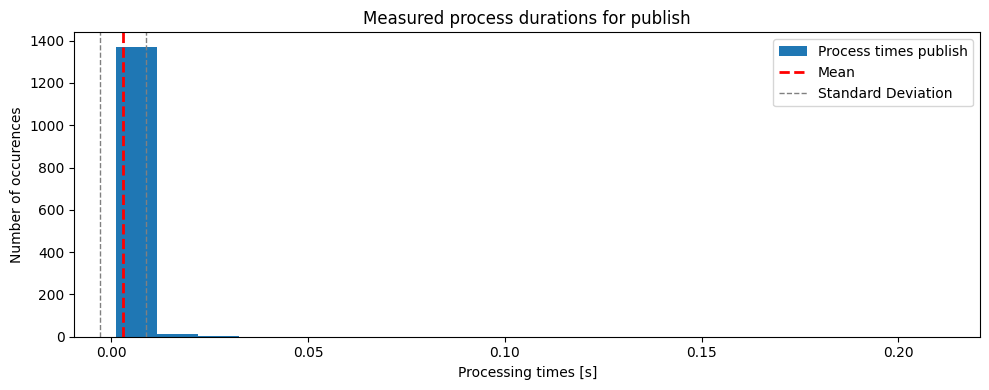

In [ ]:
binance_producer_df = pd.DataFrame(df[df.service_name == "binance_producer"])
plot_processing_histograms(binance_producer_df)

### Process times twitter processor

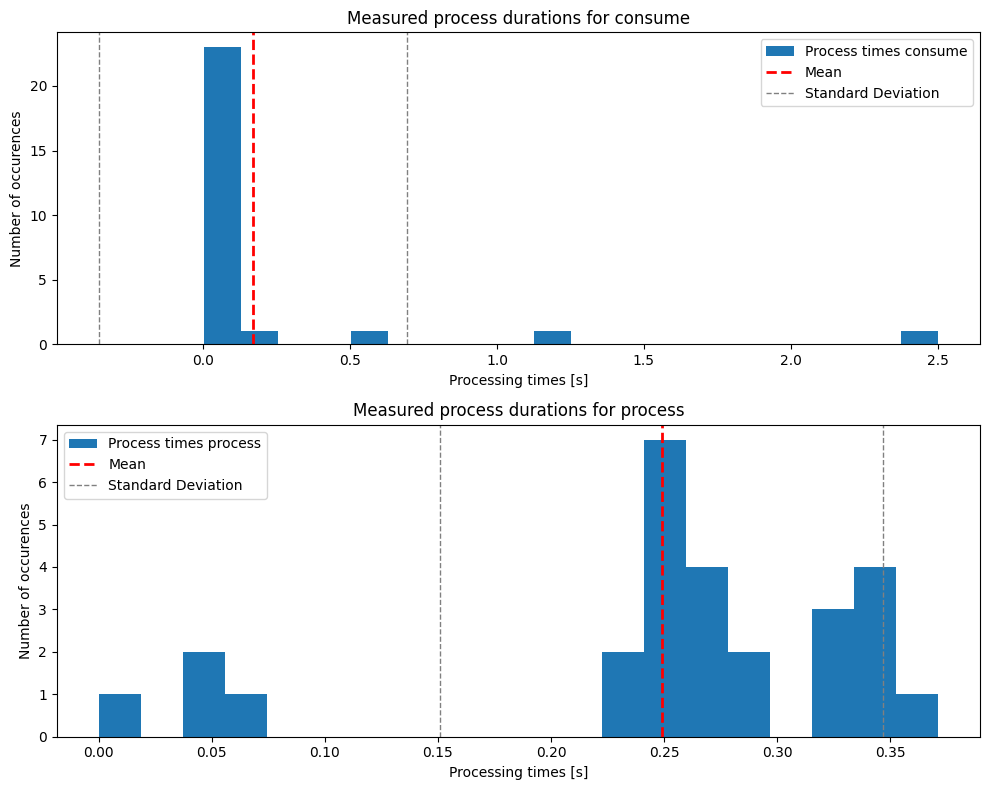

In [ ]:
twitter_processor_df = df[df.service_name == "twitter_processor"]
plot_processing_histograms(twitter_processor_df)

### Process times twitter producer

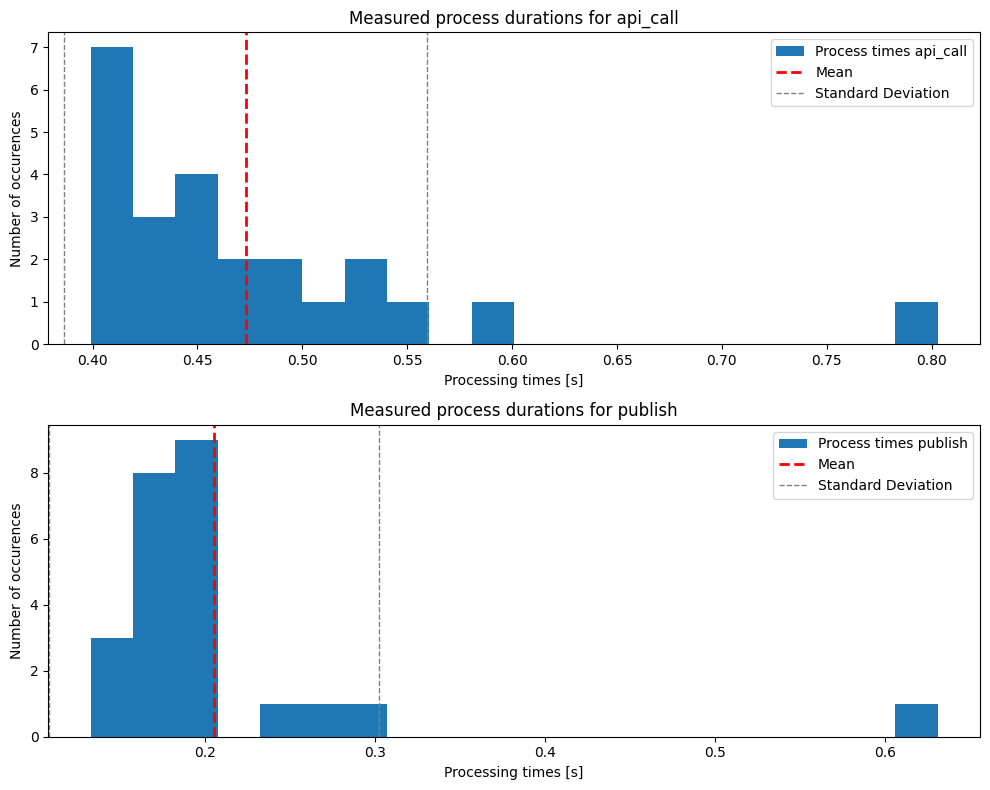

In [ ]:
twitter_producer_df = pd.DataFrame(df[df.service_name == "twitter_producer"])
plot_processing_histograms(twitter_producer_df)

In these first measurements the following points are noticable:
* Process times for twitter data are in general longer than for binance data since the twitter data is more complex than the binance data
* There are some fluctuations (smaller than 1s) in the Process times for publishing and consuming to and from the cluster

### Experiment 1
In the first experiment the producer and consumer services are scaled by a factor of 10. The exception is the Twitter Producer because of the API limitations. The amount of brokers in the Kafka Cluster stays the same. The intent of this experiment is to determine, how the performance of the cluster is affected when the number of producers and consumers is increased. 

In [ ]:
three_broker_secrets()
!cd notebooks && docker compose -f docker-compose.experiment1.yml up --build -d --scale binance_producer=10 --scale binance_processor=10

start = datetime.now()

completed_measurement = False

while completed_measurement == False:
    if (datetime.now() - start).seconds >= 5 * 60:
        completed_measurement = True
    else:
        time.sleep(1)

!cd notebooks && docker compose down

[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (1/1)                                                         
 => [notebooks-twitter_processor internal] load build definition from Doc  0.0s
 => => transferring dockerfile: 309B                                       0.0s
[+] Building 0.2s (1/2)                                                         
 => [notebooks-twitter_process

In [ ]:
for filename in os.listdir("notebooks/data_experiment1"):
    if filename.startswith("pe"):
        df = pd.read_pickle("notebooks/data_experiment1/" + filename)

for filename in os.listdir("notebooks/data"):
    if filename.startswith("pe"):
        baseline_df = pd.read_pickle("notebooks/data/" + filename)

### Process times binance processor

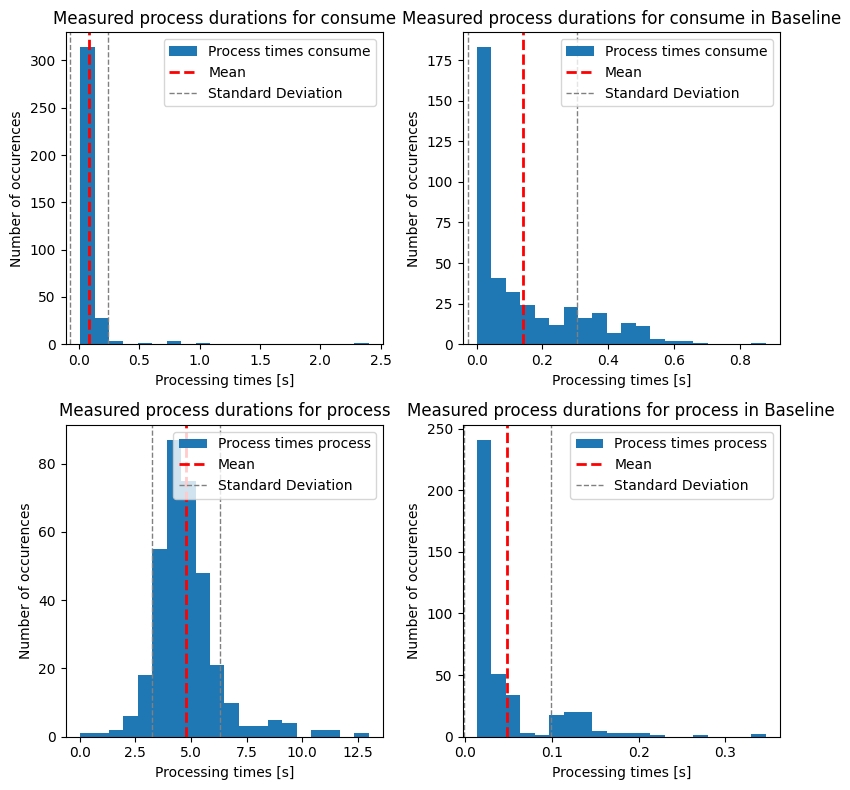

In [ ]:
binance_processor_df = df[df.service_name == "binance_processor"]
binance_baseline_processor_df = baseline_df[baseline_df.service_name == "binance_processor"]
plot_comparison_to_baseline(binance_baseline_processor_df, binance_processor_df)

The processing time for the binance data increased greatly since the amount of data published and consumed from the cluster is ten times greater. The time used for consuming data from the cluster hasn't changed all that much. Another bottleneck is the single file all consumers have to write to. 

### Process times binance producer

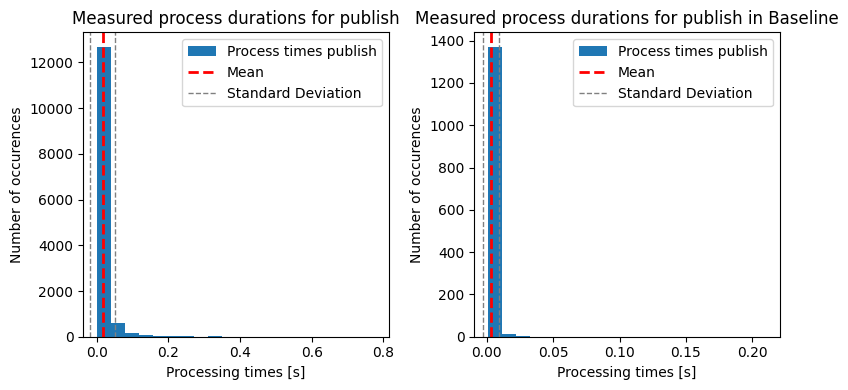

In [ ]:
binance_processor_df = df[df.service_name == "binance_producer"]
binance_baseline_processor_df = baseline_df[baseline_df.service_name == "binance_producer"]
plot_comparison_to_baseline(binance_baseline_processor_df, binance_processor_df)

The publishing of the binance data is not taking significantly longer than in the Baseline architecture. There are greater fluctuations noticable compared to the Baseline model. 

### Process times twitter processor

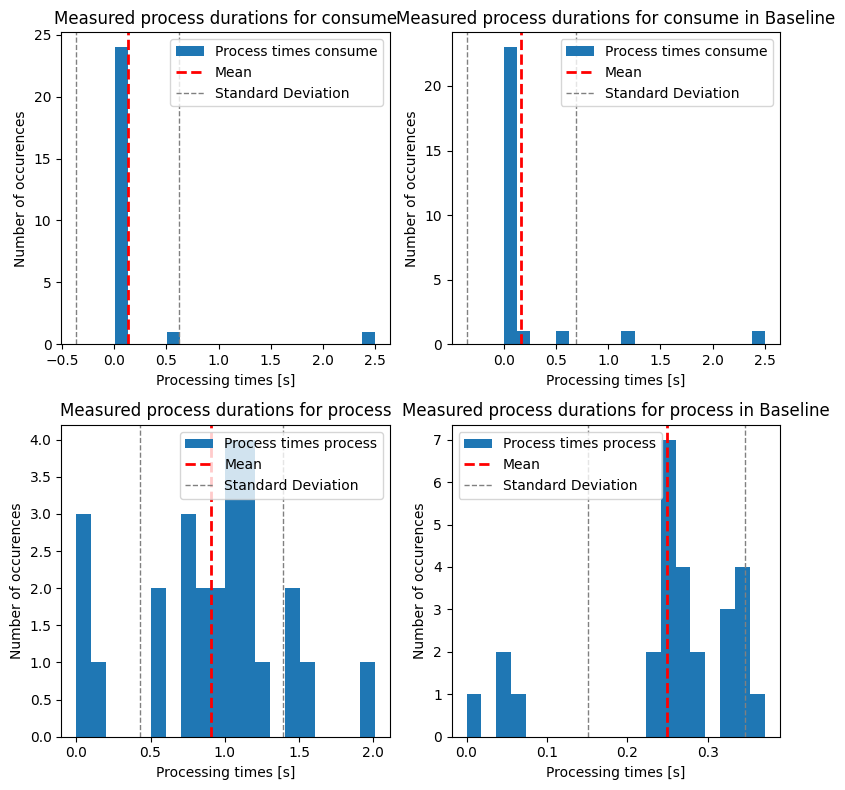

In [ ]:
binance_processor_df = df[df.service_name == "twitter_processor"]
binance_baseline_processor_df = baseline_df[baseline_df.service_name == "twitter_processor"]
plot_comparison_to_baseline(binance_baseline_processor_df, binance_processor_df)

Surprisingly, the processing time for the twitter data increased too. Although the containers for twitter stayed exactly the same.  This is probably because there are less ressources available from the machine since more containers are running. 

### Process times twitter producer

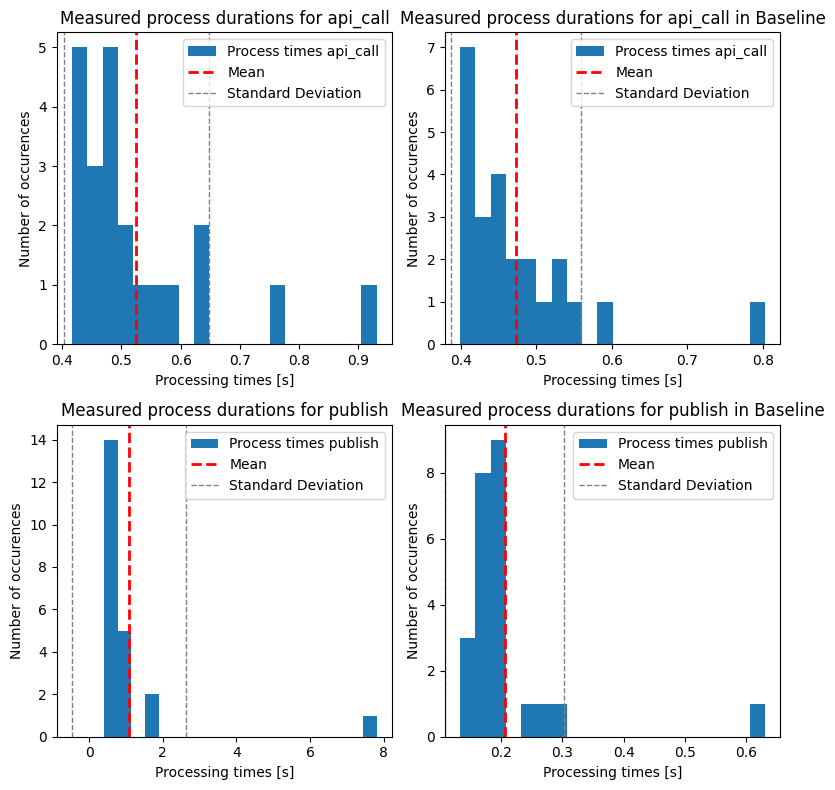

In [ ]:
binance_processor_df = df[df.service_name == "twitter_producer"]
binance_baseline_processor_df = baseline_df[baseline_df.service_name == "twitter_producer"]
plot_comparison_to_baseline(binance_baseline_processor_df, binance_processor_df)

Publishing twitter data also took significantly longer than before. This could also be because the ressources are more scarce because more containers are running. 

### Comparison of function calls

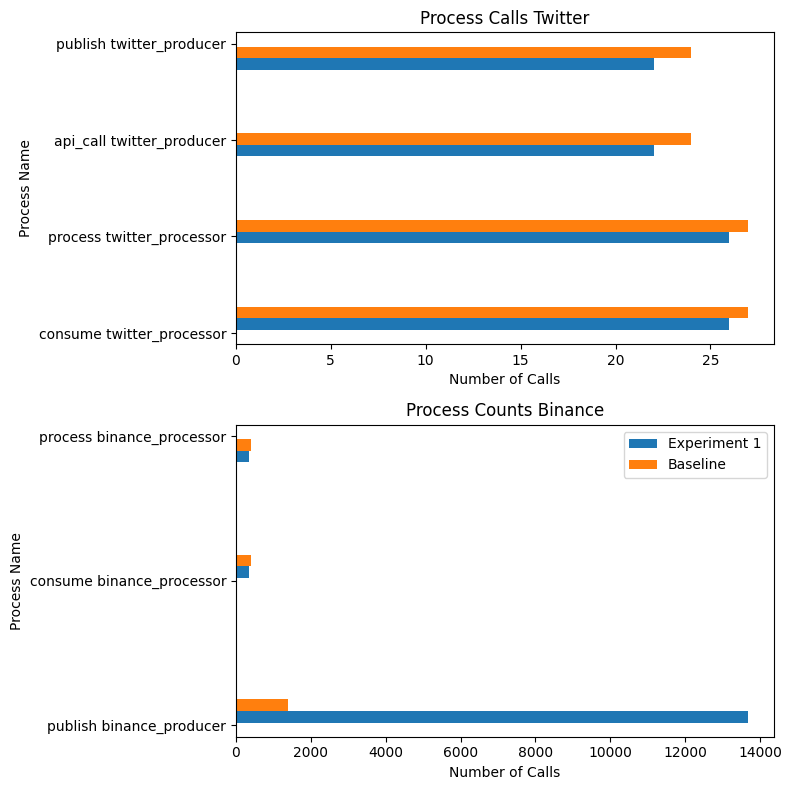

In [ ]:
compare_function_calls(df, baseline_df, ['Experiment 1', "Baseline"])

In the visualization above, the change in the number of function calls is clearly visible. 

### Experiment 2
In the second experiment the producer and consumer services are again scaled by 10, but the number of brokers is doubled. The intent of this experiment is to determine, how the performance of the cluster is affected, when the amount of brokers within the cluster is increased. 

The performance of Experiment 2 is compared to Experiment 1.

In [ ]:
six_broker_secrets()
!cd notebooks && docker compose -f docker-compose.experiment2.yml up --build -d --scale binance_producer=10 --scale binance_processor=10

start = datetime.now()

completed_measurement = False

while completed_measurement == False:
    if (datetime.now() - start).seconds >= 5 * 60:
        completed_measurement = True
    else:
        time.sleep(1)

!cd notebooks && docker compose down

[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.1s (1/2)                                                         
 => [notebooks-pe internal] load build definition from DockerFile.pe       0.0s
 => => transferring dockerfile: 242B                                       0.0s
[+] Building 0.3s (6/6)                                                         
 => [notebooks-pe internal] load build definition from DockerFile.pe       0.0s
 => => transferring dockerfile:

In [ ]:
# loading performance data
for filename in os.listdir("notebooks/data_experiment2"):
    if filename.startswith("pe"):
        df = pd.read_pickle("notebooks/data_experiment2/" + filename)

for filename in os.listdir("notebooks/data_experiment1"):
    if filename.startswith("pe"):
        baseline_df = pd.read_pickle("notebooks/data_experiment1/" + filename)

### Process times binance processor

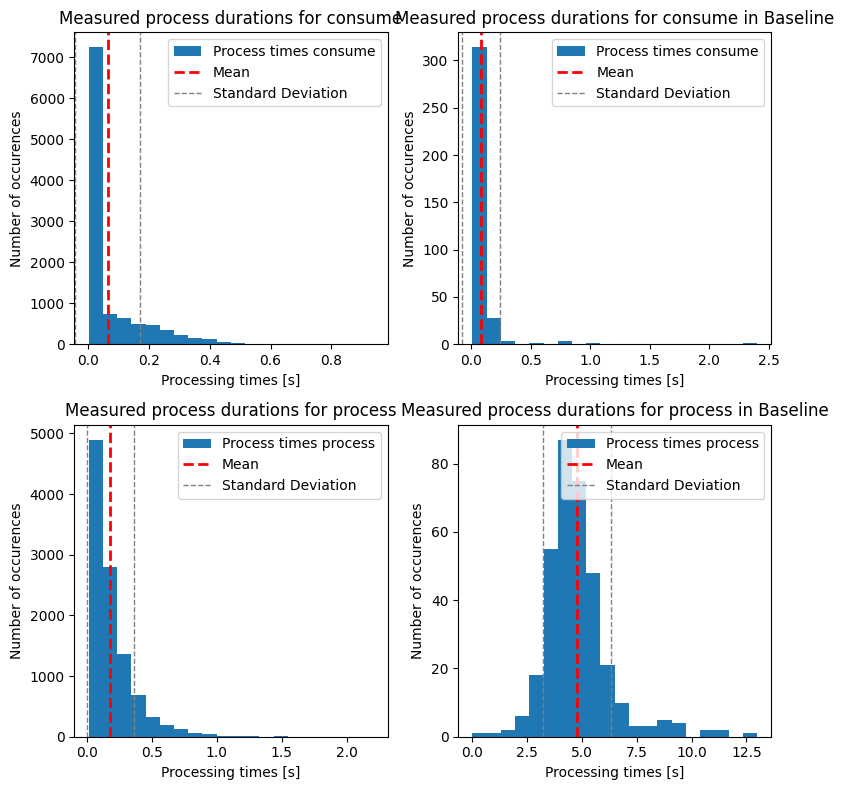

In [ ]:
binance_processor_df = df[df.service_name == "binance_processor"]
binance_baseline_processor_df = baseline_df[baseline_df.service_name == "binance_processor"]
plot_comparison_to_baseline(binance_baseline_processor_df, binance_processor_df)

The time used for consuming and processing messages was reduced by doubling the number of brokers. Since more brokers are available, more processors can access the cluster. This reduces the amount of data that needs to be processed and thus reduces the processing time. This should increase the number of calls for the processing function.

### Process times binance producer

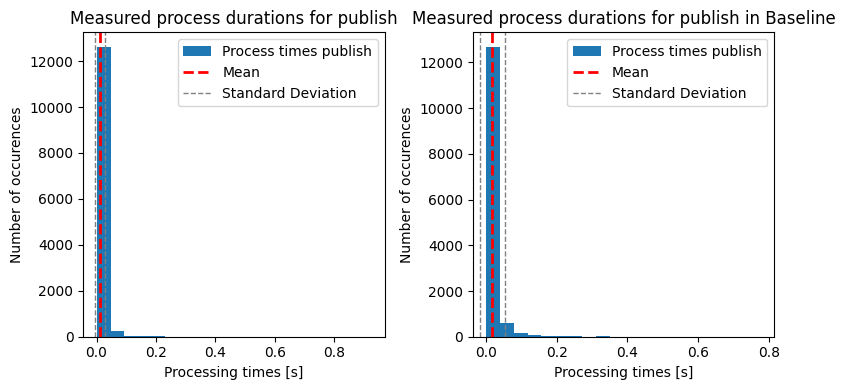

In [ ]:
binance_processor_df = df[df.service_name == "binance_producer"]
binance_baseline_processor_df = baseline_df[baseline_df.service_name == "binance_producer"]
plot_comparison_to_baseline(binance_baseline_processor_df, binance_processor_df)

The durations for publishing seem to be more stable in Experiment 2 than in Experiment 1 although the difference is small. The more stable durations for publishing can be linked to the increased number of available brokers too. 

### Process times twitter processor

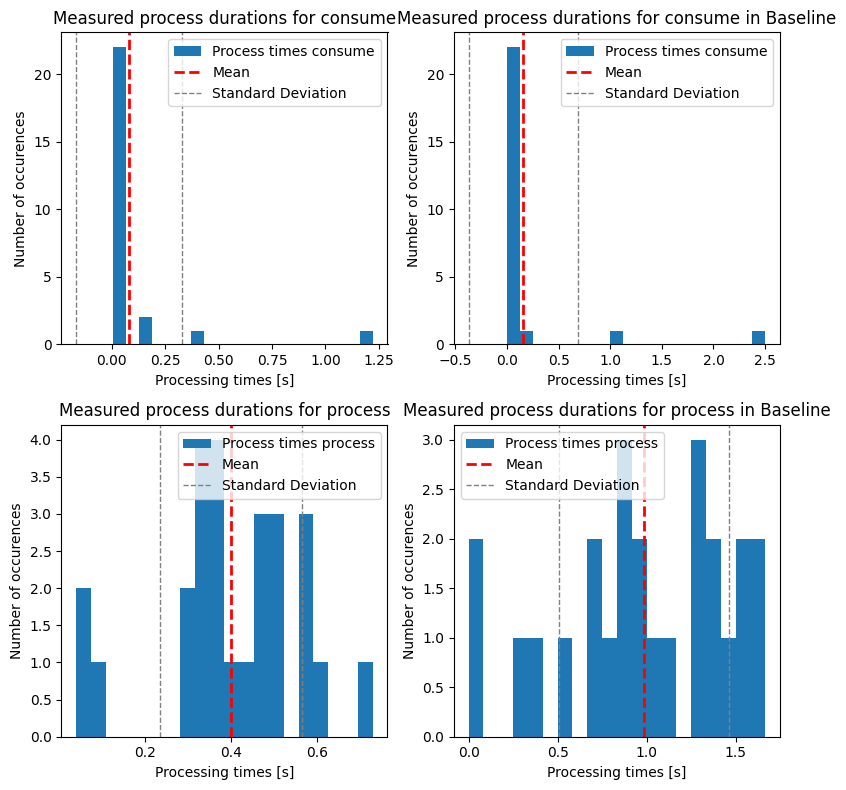

In [ ]:
binance_processor_df = df[df.service_name == "twitter_processor"]
binance_baseline_processor_df = baseline_df[baseline_df.service_name == "twitter_processor"]
plot_comparison_to_baseline(binance_baseline_processor_df, binance_processor_df)

### Process times twitter producer

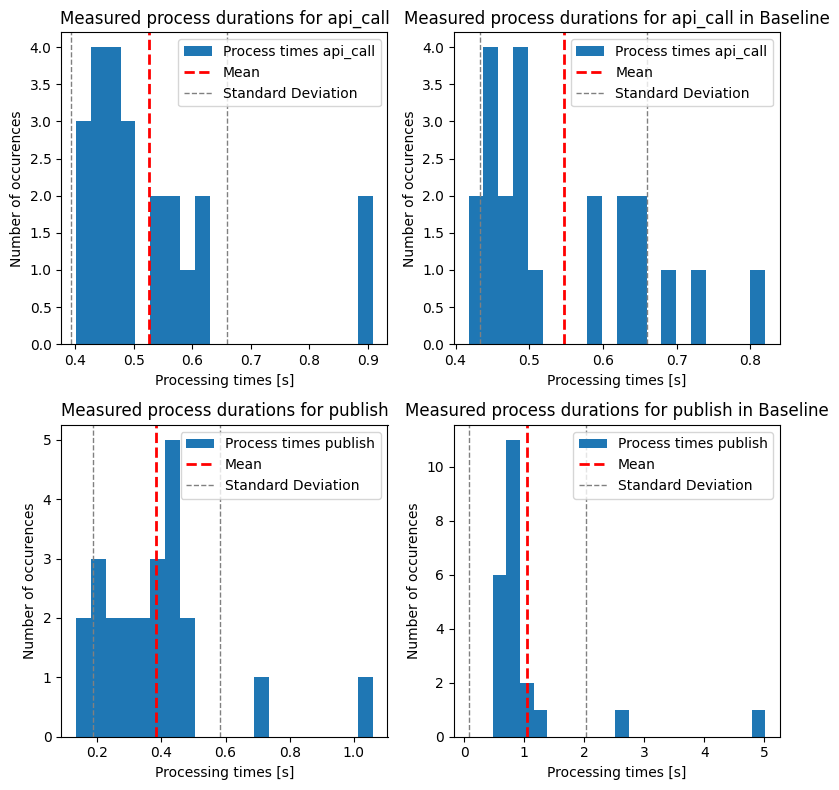

In [ ]:
binance_processor_df = df[df.service_name == "twitter_producer"]
binance_baseline_processor_df = baseline_df[baseline_df.service_name == "twitter_producer"]
plot_comparison_to_baseline(binance_baseline_processor_df, binance_processor_df)

The duration for publishing fetched tweets has been reduced too because of the higher availability of the brokers.

### Comparison of function calls 

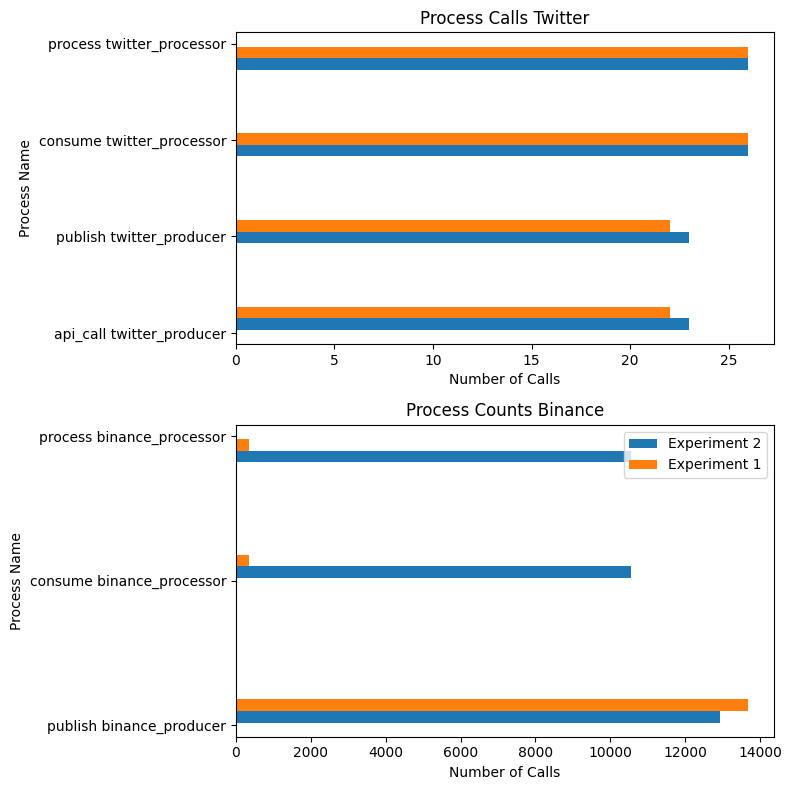

In [ ]:
compare_function_calls(df, baseline_df, ['Experiment 2', "Experiment 1"])

The visualization above confirms the suspected reason for the lowered times of the data processing functions. The number of consume calls has greatly increased, as has the number of process calls. 

### Experiment 3
In the third experiment the producer and consumer services are scaled by a factor of 10, the number of brokers is the same as in experiment 2, six. What changes is the replication factor for the topics. The intent of the experiment is to show how the replication factor affects the performance of the cluster. 

The performance data of Experiment 3 is compared to the data of Experiment 2. 

In [ ]:
six_broker_secrets()
!cd notebooks && docker compose -f docker-compose.experiment3.yml up --build -d --scale binance_producer=10 --scale binance_processor=10

start = datetime.now()

completed_measurement = False

while completed_measurement == False:
    if (datetime.now() - start).seconds >= 5 * 60:
        completed_measurement = True
    else:
        time.sleep(1)

!cd notebooks && docker compose down

[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.1s (1/1)                                                         
 => [notebooks-twitter_processor internal] load build definition from Doc  0.0s
 => => transferring dockerfile: 309B                                       0.0s
[+] Building 0.2s (5/6)                                                         
 => [notebooks-twitter_processor internal] load build definition from Doc  0.0s
 => => transferring dockerfile:

In [ ]:
# loading performance data
for filename in os.listdir("notebooks/data_experiment3"):
    if filename.startswith("pe"):
        df = pd.read_pickle("notebooks/data_experiment3/" + filename)

for filename in os.listdir("notebooks/data_experiment2"):
    if filename.startswith("pe"):
        baseline_df = pd.read_pickle("notebooks/data_experiment2/" + filename)

### Process times binance processor

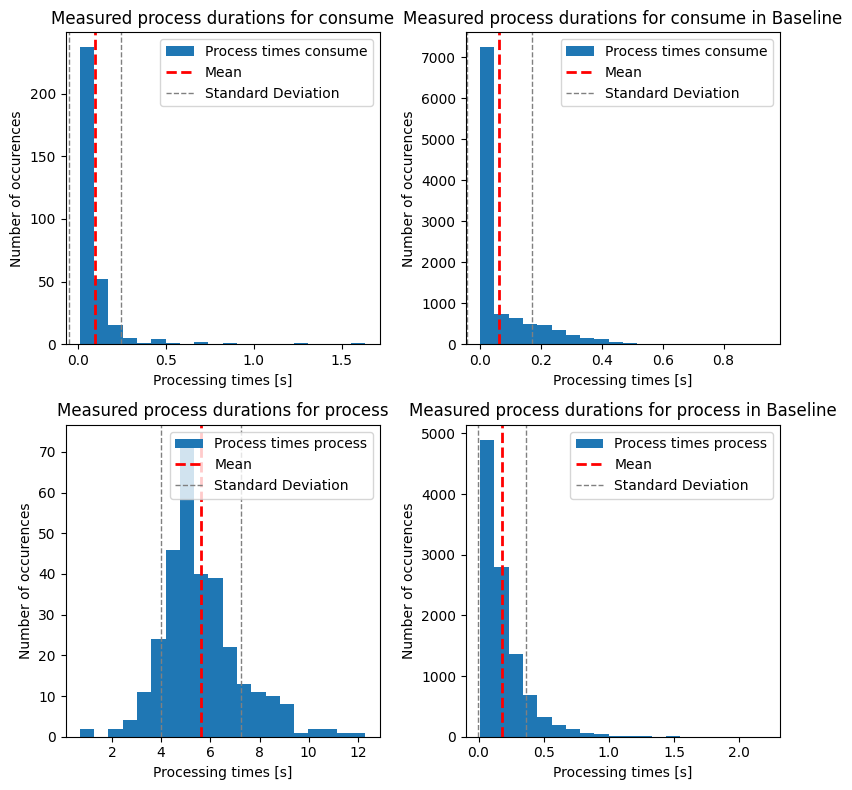

In [ ]:
binance_processor_df = df[df.service_name == "binance_processor"]
binance_baseline_processor_df = baseline_df[baseline_df.service_name == "binance_processor"]
plot_comparison_to_baseline(binance_baseline_processor_df, binance_processor_df)

Since the replication factor of the cluster is set to 3, a higher processing time is expected. The processing time has now increased again and the average duration for consuming a message increased too. The variability for consuming has increased to. 

### Process times binance producer

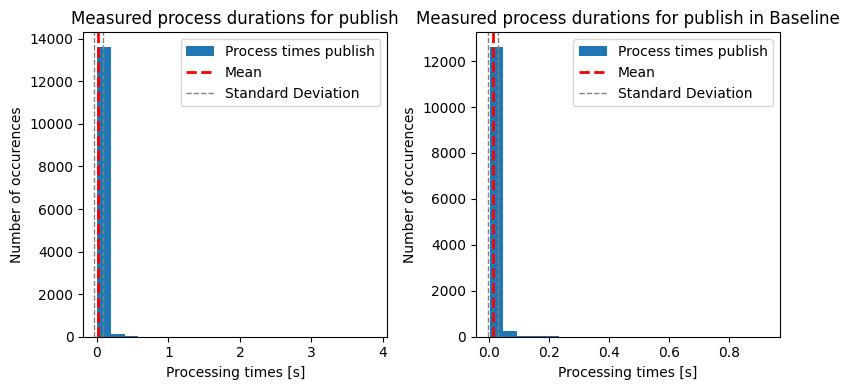

In [ ]:
binance_processor_df = df[df.service_name == "binance_producer"]
binance_baseline_processor_df = baseline_df[baseline_df.service_name == "binance_producer"]
plot_comparison_to_baseline(binance_baseline_processor_df, binance_processor_df)

The average time for publishing a message to the cluster has increased slighty as visible in the visualization above. More noticable is the increase in variability of the duration for the publishing time. This is because of the bigger workload on the cluster. 

### Process times twitter processor

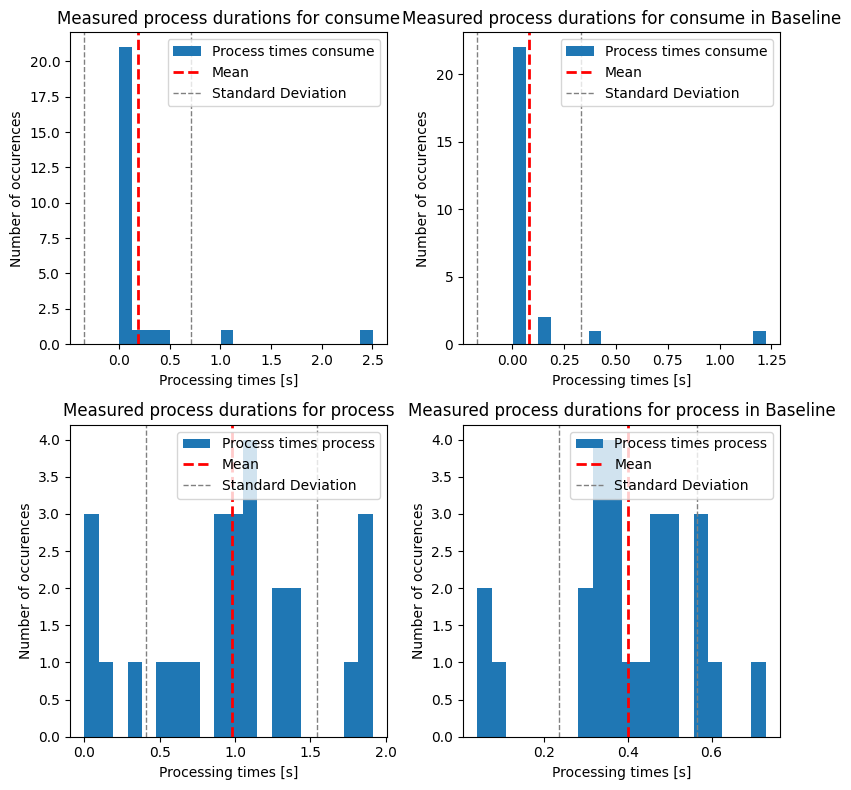

In [ ]:
binance_processor_df = df[df.service_name == "twitter_processor"]
binance_baseline_processor_df = baseline_df[baseline_df.service_name == "twitter_processor"]
plot_comparison_to_baseline(binance_baseline_processor_df, binance_processor_df)

The average time for consuming messages from the twitter topic has increased again, has has the variability. The same goes for the processing times. The consume times have increased because the cluster is under a bigger workload. The processing time probably has increased because the ressources are scarcer than compared to Experiment 2. 

### Process times twitter producer

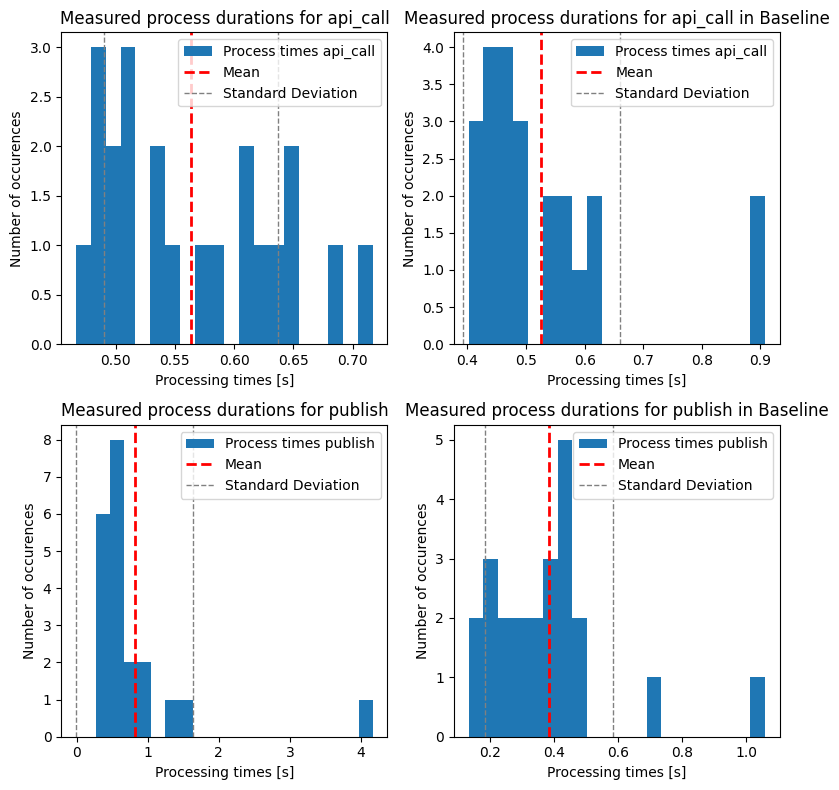

In [ ]:
binance_processor_df = df[df.service_name == "twitter_producer"]
binance_baseline_processor_df = baseline_df[baseline_df.service_name == "twitter_producer"]
plot_comparison_to_baseline(binance_baseline_processor_df, binance_processor_df)

A similar pattern is visible for the twitter producer. Publishing the messages took a lot longer compared to experiment 2. 

### Comparison of function calls

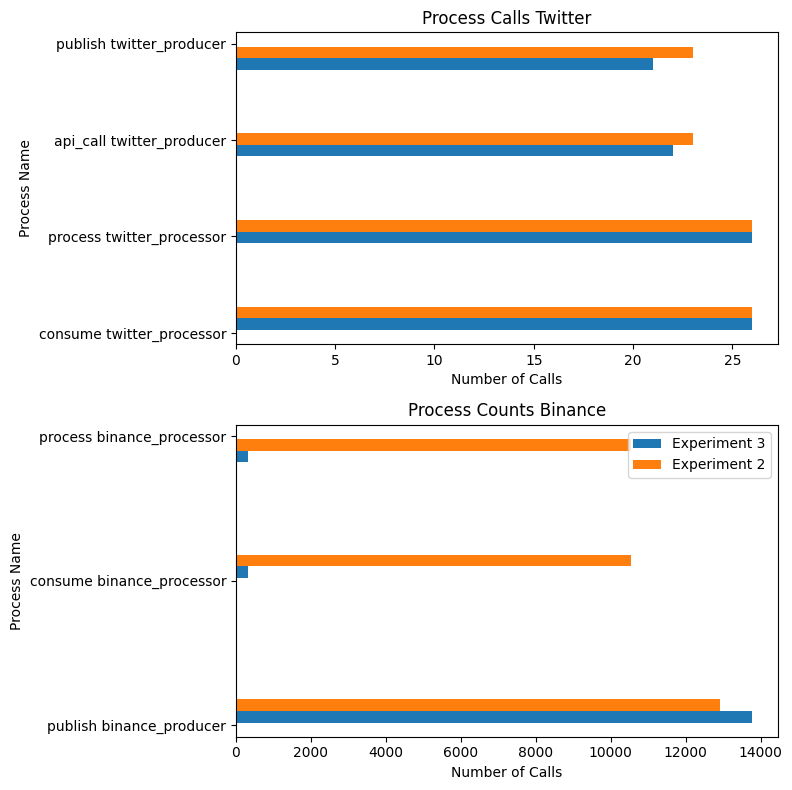

In [ ]:
compare_function_calls(df, baseline_df, ['Experiment 3', "Experiment 2"])

The third experiment produced similar results to experiment 1. The amount of calls is reduced and the amount of data per call is increased. This results in longer processing times. 

### Mitigating a bottleneck

One bottleneck that occured when scaling the binance producers and consumers is the processing of the larger amount of messages. Pandas doesn't allow for multiprocessing but implementing the calculations with Dask would. The new binance_processor is implemented in the *binance_processor_multiprocessing.py* file. The whole cluster can be started with *docker-compose.mitigate_bottleneck.yml*. 

In [4]:
three_broker_secrets()
!cd notebooks && docker compose -f docker-compose.mitigate_bottleneck.yml up --build -d --scale binance_producer=10 --scale binance_processor=10

start = datetime.now()

completed_measurement = False

while completed_measurement == False:
    if (datetime.now() - start).seconds >= 5 * 60:
        completed_measurement = True
    else:
        time.sleep(1)

!cd notebooks && docker compose down

[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/0)                                                         
[+] Building 0.0s (0/1)                                                         
[+] Building 0.1s (1/2)                                                         
 => [notebooks-twitter_producer internal] load build definition from Dock  0.0s
 => => transferring dockerfile: 307B                                       0.0s
[+] Building 0.2s (5/6)                                                         
 => [notebooks-twitter_produce

In [5]:
# loading performance data
for filename in os.listdir("notebooks/data_bottleneck"):
    if filename.startswith("pe"):
        df = pd.read_pickle("notebooks/data_bottleneck/" + filename)

for filename in os.listdir("notebooks/data_experiment1"):
    if filename.startswith("pe"):
        baseline_df = pd.read_pickle("notebooks/data_experiment1/" + filename)

#### Comparing Process Times of the binance processor

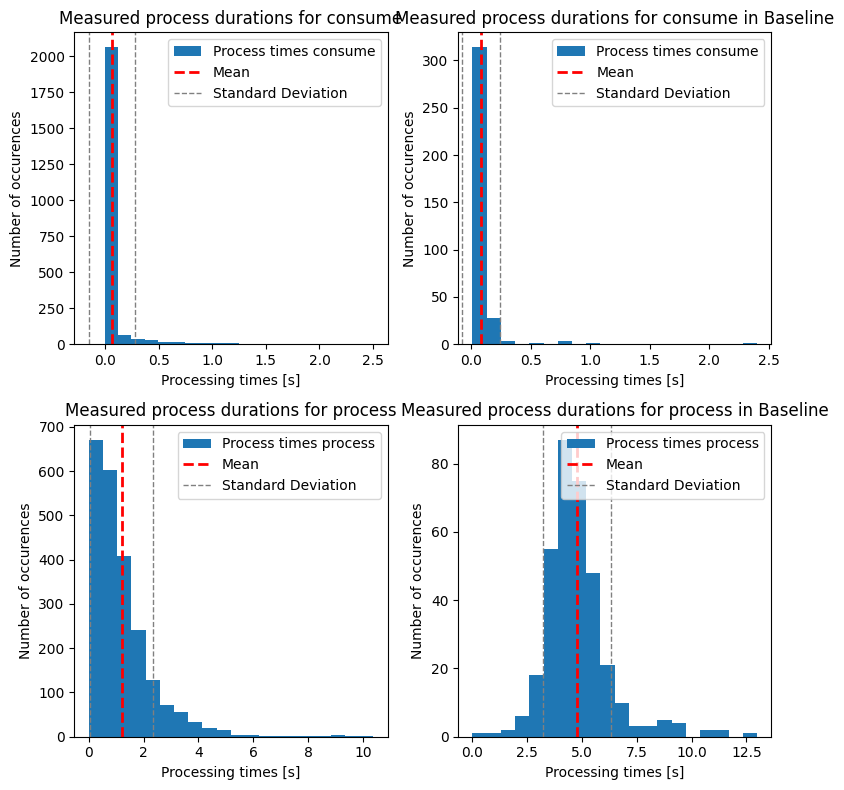

In [8]:
binance_processor_df = df[df.service_name == "binance_processor"]
binance_baseline_processor_df = baseline_df[baseline_df.service_name == "binance_processor"]
plot_comparison_to_baseline(binance_baseline_processor_df, binance_processor_df)

With the multiprocessing of the binance data the bottleneck was not completely mitigated but the average processing time is now less than half of the original processing time. The distribution of the processing times now looks completely different than before. 

### Visualization of processer code
All snakeviz visualisations where generated with the docker-compose.kafka_only.yml file. After launching all containers the scripts where launched with the profiling.  

#### Twitter Producer

The largest part of the measured time is spent in within the sleep function because the Producer has to wait 10 seconds after every API call to stay within limitations. The other tiles are from the requests module.

![](image/twitter_producer.png)

#### Twitter processor
The processor spends the largest part of the measured time within the sleeping function, waiting for the next execution. The second largest tile, the bright orange one, is spent processing the data from the consumed messages. This is somewhat expensive since sentiment for text has to be calculated. The bright blue tile is the time spent consuming messages from kafka. 

![](image/twitter_processor.png)

#### Binance Producer

The visualisation for the binance producer is hard to interpret without detailed knowledge of the websockets library. Most of the time is spent within functions from the websockets library.

![](image/binance_producer.png)

#### Binance Processor

The binance processor spends the a big portion of the time within the consume_messages function. The datetime function which the processor spends 12 s in is the function before the processor waits until processing the next batch of information. The third biggest tile represents the data processing. It is visible as a built-in method. 

![](image/binance_processor.png)

### Detected bottlenecks

#### Twitter API
One bottleneck is the Twitter API. The API is limited and only allows retrieving around 100 Tweets every ten seconds. Since the Authentication works over a single token, creating multiple services does not improve the throughput. There is the possibility of webscraping tweets, but the speed would be even worse. There is no possible solution other to request less strict limitation from twitter. 

#### Processing of Binance Data
The processing of the collected Binance Data takes the longest. The processing is implemented with a pandas DataFrame and doesn't use any multiprocessing. A possible solution would be the usage of a dask DataFrame which would allow for faster multiprocessing. This is only necessary when multiple clients are writing to the kafka cluster. With a single producer and consumer, there is no real bottleneck available. 

#### Data sink
The implementations of a data sink with the HDF5 Files is also a bottleneck, although only for the experiments. When multiple instances are running only one instance at a time can write into the file. A possible solution would be a database or a distributed filesystem like hadoop. This would allow multiple instances writing at the same time. 

## Reflection
### What went well?
The implementation of the different producers and processors aswell as the connection to the API and binance websocket went well and the services where running stable pretty quick. 

### Where did problems occur?
The networking with the different docker containers was difficult. The key learning points were:
* Docker has it's own subnet
* Specifying a hostname and using the 'expose' function for a port enables easy communication between containers with "hostname":"port". Exposing a port with expose doesn't map the port on the local machine. 
* Exposing the port with the 'ports' function maps the port of the container to a port on the local machine. Can be accesed with localhost:"port". Accessing this port on the container would require the knowledge of the local ip address from the container. Therefor the expose solution is neater. 
* The hierarchical filesystem of docker can be used if multiple services rely on the same requirements. Using the same order in multiple DockeFiles results in faster building. 
* Mapping the volume of a docker container with the 'volume' function in a docker compose file if data has to be persisted
* Not specifying a container_name within the docker-compose file allows for scaling multiple containers with a single command.

When scaling the binance processors obviously problems occured when writing to the same file from multiple instances. Obviously writing to the same file from multiple instances would result in a corrupted file. When opening a file in python, the file is auotmatically blocked and not accessible by other services. That's why 'BlockingIOError' exceptions are necessary. 

Wasn't really my problem but useful anyways: Using the '-u' flag when executing a python script doesn't buffer the output. Especially useful when working with docker containers. 

### Where did you need more time than planned?
* Setting up the different docker-compose files took longer than expected, but that's not surprising since I've never worked with them before. 
* The implementation of the three experiments was time consuming. I had to change the storage solution for the PerformanceEvaluator from files to a topic within kafka to allow for simulataneous writing from multiple sources.
* There seems to be a difference between running zeromq from the console and runnig zeromq in docker containers. When connecting to a socket, the service that is already bound to that port receives different messages when a new socket connects. During the first implementation I used a Monitor socket but when launched in the different docker containers, this didn't detect incoming connections. With using a Poller, it detects new connections on the socket when zeromq is started from the commandline and when it's containerized. 

### What would you do differently in the future?
I would setup a database or a distributed filesystem as the datasink and for persisting performance metrics. This would allow for writing from multiple instances simultaneously and would clean up the code of the processors and producers. A drawback would be the increased workload and the more complex setup. 

### What would you change in the assignment?
Using jupyter notebooks for developing the different data generators and data processors may be fine but it would make more sense to develop them in Python Files from the start considering the later requirement of using a docker-compose to start all the processes. 

### Other key learning points
* When creating websockets with zeromq: The socket itself has a buffer too. A certain amount of messages can be queued. 